In [1]:
import os
import re
import pathlib
from glob import glob

import matplotlib.pyplot as plt
import earthaccess
import xrspatial
import geopandas as gpd
import rioxarray as rxr
import rioxarray.merge as rxrmerge

c:\Users\moenc\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
%store -r lmis_gdf bufg_gdf c_soil_url_list p_soil_url_list

In [3]:
# build project and elevation directories

data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data'
)
project_dir = os.path.join(data_dir, 'habitat_suitability')
elevation_dir = os.path.join(data_dir, 'srtm')

os.makedirs(elevation_dir, exist_ok=True)

In [4]:
# login to earthaccess
earthaccess.login(strategy="interactive", persist=True)

In [5]:
# search for the appropriate DEM

datasets = earthaccess.search_datasets(keyword='SRTM DEM', count=11)
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002


In [6]:
lmis_gdf.bounds

,minx,miny,maxx,maxy
19,-104.045593,46.280049,-102.655551,48.12513


In [ ]:
# srtm_c_results = earthaccess.search_data(
#     short_name="SRTMGL1",
#     bounding_box=bounds_buffer    
# )
# print(srtm_c_results)  # See if any results are found


NameError: name 'bounds_buffer' is not defined

In [8]:
## Creating a pattern for selecting srtm tiles based on the grassland gdf bounds

# Extract bounding box from lmis_gdf
xmin, ymin, xmax, ymax = lmis_gdf.total_bounds

# Generate SRTM tile names based on integer degree tiles
latitudes = range(int(ymin), int(ymax) + 1)
longitudes = range(int(xmin), int(xmax) + 1)

# Create SRTM file patterns
srtm_c_pattern_list = []
for lat in latitudes:
    for lon in longitudes:
        lat_prefix = f"N{lat}" if lat >= 0 else f"S{abs(lat)}"
        lon_prefix = f"E{lon}" if lon >= 0 else f"W{abs(lon)}"
        srtm_c_pattern_list.append(os.path.join(elevation_dir, f"{lat_prefix}{lon_prefix}.hgt.zip"))

# # Use glob to find matching files
# srtm_c_pattern = [glob(pattern) for pattern in srtm_c_pattern_list]
# srtm_c_pattern = [item for sublist in srtm_c_pattern for item in sublist]  # Flatten list

# print("Matching SRTM files:", srtm_c_pattern)


In [9]:
srtm_c_pattern_list

['C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N46W104.hgt.zip',
 'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N46W103.hgt.zip',
 'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N46W102.hgt.zip',
 'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N47W104.hgt.zip',
 'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N47W103.hgt.zip',
 'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N47W102.hgt.zip',
 'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N48W104.hgt.zip',
 'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N48W103.hgt.zip',
 'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N48W102.hgt.zip']

In [10]:
print(os.listdir(elevation_dir))

['N36W103.SRTMGL1.hgt.zip', 'N36W104.SRTMGL1.hgt.zip', 'N36W105.SRTMGL1.hgt.zip', 'N37W103.SRTMGL1.hgt.zip', 'N37W104.SRTMGL1.hgt.zip', 'N37W105.SRTMGL1.hgt.zip', 'N40W104.SRTMGL1.hgt.zip', 'N40W105.SRTMGL1.hgt.zip', 'N41W104.SRTMGL1.hgt.zip', 'N41W105.SRTMGL1.hgt.zip', 'N46W103.SRTMGL1.hgt.zip', 'N46W104.SRTMGL1.hgt.zip', 'N46W105.SRTMGL1.hgt.zip', 'N47W103.SRTMGL1.hgt.zip', 'N47W104.SRTMGL1.hgt.zip', 'N47W105.SRTMGL1.hgt.zip', 'N48W103.SRTMGL1.hgt.zip', 'N48W104.SRTMGL1.hgt.zip', 'N48W105.SRTMGL1.hgt.zip']


In [11]:
# Define a pattern to identify DEM tiles associated with lmis National Grassland.
srtm_c_pattern = [
    os.path.join(elevation_dir, 'N46*hgt.zip'),
    os.path.join(elevation_dir, 'N47*hgt.zip'),
    os.path.join(elevation_dir, 'N48*hgt.zip')
]
bounds_c = tuple(lmis_gdf.total_bounds)
buffer = 0.25
xmin, ymin, xmax, ymax = bounds_c
bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

# Fix the first code block.
all_files = []
for pattern in srtm_c_pattern:
    all_files.extend(glob(pattern))

if not all_files:
    srtm_c_results = earthaccess.search_data(
        short_name="SRTMGL1",
        bounding_box=bounds_c
    )
    srtm_c_results = earthaccess.download(srtm_c_results, elevation_dir)

# if not glob(srtm_c_pattern):
#     srtm_c_results = earthaccess.search_data(
#         short_name = "SRTMGL1",
#         bounding_box=bounds_buffer    
#     )
#     srtm_c_results = earthaccess.download(srtm_c_results, elevation_dir)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

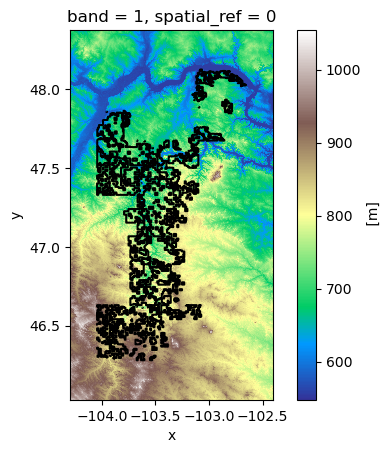

In [ ]:
# # Print the DEM for lmis natl. Grassland
# srtm_c_da_list=[]
# for srtm_c_path in glob(srtm_c_pattern):
#     tile_da = rxr.open_rasterio(srtm_c_path, mask_and_scale=True).squeeze()
#     cropped_da = tile_da.rio.clip_box(*bounds_buffer)
#     srtm_c_da_list.append(cropped_da)
    
# srtm_c_da = rxrmerge.merge_arrays(srtm_c_da_list)
# srtm_c_da.plot(cmap='terrain')
# lmis_gdf.boundary.plot(ax=plt.gca(), color='black')

# Fix the second code block.
srtm_c_da_list = []
for pattern in srtm_c_pattern:
    for srtm_c_path in glob(pattern):
        tile_da = rxr.open_rasterio(srtm_c_path, mask_and_scale=True).squeeze()
        cropped_da = tile_da.rio.clip_box(*bounds_buffer)
        srtm_c_da_list.append(cropped_da)

srtm_c_da = rxrmerge.merge_arrays(srtm_c_da_list)
srtm_c_da.plot(cmap='terrain')
lmis_gdf.boundary.plot(ax=plt.gca(), color='white')

In [20]:
%store srtm_c_da

Stored 'srtm_c_da' (DataArray)


In [14]:
srtm_p_results = earthaccess.search_data(
    short_name="SRTMGL1",
    bounding_box=bounds_buffer    
)
print(srtm_p_results)  # See if any results are found


[Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -103.00027778, 'EastBoundingCoordinate': -101.99972222, 'NorthBoundingCoordinate': 48.00027778, 'SouthBoundingCoordinate': 46.99972222}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '2000-02-21T23:59:59.000Z'}}
Size(MB): 7.06691
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/SRTMGL1.003/N47W103.SRTMGL1.hgt/N47W103.SRTMGL1.hgt.zip'], Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -103.00027778, 'EastBoundingCoordinate': -101.99972222, 'NorthBoundingCoordinate': 47.00027778, 'SouthBoundingCoordinate': 45.99972222}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '20

In [15]:
## Creating a pattern for selecting srtm tiles based on the grassland gdf bounds

# Extract bounding box from lmis_gdf
xmin, ymin, xmax, ymax = lmis_gdf.total_bounds

# Generate SRTM tile names based on integer degree tiles
latitudes = range(int(ymin), int(ymax) + 1)
longitudes = range(int(xmin), int(xmax) + 1)

# Create SRTM file patterns
srtm_c_pattern_list = []
for lat in latitudes:
    for lon in longitudes:
        lat_prefix = f"N{lat}" if lat >= 0 else f"S{abs(lat)}"
        lon_prefix = f"E{lon}" if lon >= 0 else f"W{abs(lon)}"
        srtm_c_pattern_list.append(os.path.join(elevation_dir, f"{lat_prefix}{lon_prefix}.hgt.zip"))

# # Use glob to find matching files
# srtm_c_pattern = [glob(pattern) for pattern in srtm_c_pattern_list]
# srtm_c_pattern = [item for sublist in srtm_c_pattern for item in sublist]  # Flatten list

# print("Matching SRTM files:", srtm_c_pattern)

In [16]:
# define a pattern which identifies the DEM's belongning to bufg National Grasslands

srtm_p_pattern = os.path.join(elevation_dir, 'N*hgt.zip')
bounds_p = tuple(bufg_gdf.total_bounds)
if not glob(srtm_p_pattern):
    srtm_p_results = earthaccess.search_data(
        short_name = "SRTMGL1",
        bounding_box=bounds_p    
    )
    srtm_p_results = earthaccess.download(srtm_p_results, elevation_dir)

In [17]:
srtm_p_pattern

'C:\\Users\\moenc\\earth-analytics\\data\\srtm\\N*hgt.zip'

In [18]:
bounds_p

(np.float64(-104.05471990000001),
 np.float64(43.00061605000002),
 np.float64(-101.47232584),
 np.float64(43.994591850000006))

In [19]:
# Print the DEM for bufg natl. Grassland
srtm_p_da_list=[]
for srtm_p_path in glob(srtm_p_pattern):
    tile_da = rxr.open_rasterio(srtm_p_path, mask_and_scale=True).squeeze()
    try:
        cropped_da = tile_da.rio.clip_box(*bounds_p)
    except: 
        continue
    srtm_p_da_list.append(cropped_da)
    
srtm_p_da = rxrmerge.merge_arrays(srtm_p_da_list)
srtm_p_da.plot(cmap='terrain')
bufg_gdf.boundary.plot(ax=plt.gca(), color='black')

IndexError: list index out of range

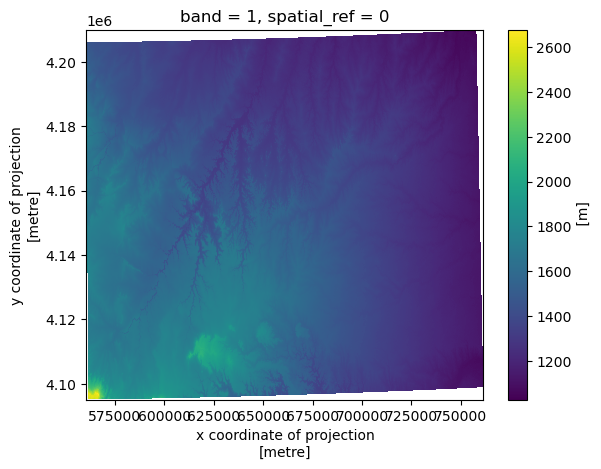

In [ ]:
# reproject the lmis DEM into utm 13 N crs
utm_13n_epsg = 32613
srtm_c_proj_da = srtm_c_da.rio.reproject(utm_13n_epsg)
# srtm_p_proj_da = srtm_da.to_crs()
srtm_c_proj_da.plot()

In [ ]:
# Reproject so units are in meters
utm13_epsg = 32613
srtm_c_proj_da = srtm_c_da.rio.reproject(utm13_epsg)
lmis_proj_gdf = lmis_gdf.to_crs(utm_13n_epsg)
bounds_proj = tuple(lmis_proj_da.total_bounds)

# Calculate slope
slope_full_da = xrspatial.slope(srtm_c_proj_da)
# slope_da = slope_full_da.rio.clip_box(*bounds_proj)
slope_da = slope_full_da.rio.clip(lmis_proj_gdf.geometry)

# Plot slope, with lmis bounds overlay
slope_c_da.plot(cmap='terrain')
lmis_proj_gdf.boundary.plot(ax=plt.gca(), color='white', linewidth=.5)
plt.show()

NameError: name 'comanche_proj_da' is not defined